In [11]:
from sklearn.datasets import make_regression, load_boston
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler

X, y = make_regression(n_samples=1000, n_features=3, noise=0.1)
colors = ['red','blue']
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

def gaussian_kernel(x1, x2, gamma):
    return np.exp(-gamma * LA.norm(x1-x2, axis=-1)**2)

def poly_kernel(x1, x2, degree=3, r=2, gamma=1):
    return (np.dot(x1.T, x2) * gamma + r) ** degree

def sigmoid_kernel(x1, x2, gamma=1, r=1):
    return np.tanh(gamma * np.dot(x1.T, x2) + r)

def laplacian_kernel(x1, x2, gamma):
    return np.exp(-gamma * LA.norm(x1-x2, axis=-1, ord=1))

m,n = X_train.shape
K = np.zeros((m, m))
gamma = 1 / ((X_train.shape[-1]) * X_train.var())
for i, x_i in enumerate(X_train):
    for j, x_j in enumerate(X_train):
        K[i, j] = gaussian_kernel(x_i, x_j, gamma)

In [12]:
C = 10
epsilon = 0.1
P = matrix(np.hstack((np.vstack((K, -K)), np.vstack((-K, K)))))
q = matrix(np.vstack(((epsilon+y_train).reshape(y_train.shape[0], 1), (epsilon-y_train).reshape(y_train.shape[0], 1))))
G = matrix(np.vstack((np.eye(2*m)*-1,np.eye(2*m))))
h = matrix(np.hstack((np.zeros(2*m), np.ones(2*m) * C)))
A = matrix(np.hstack((np.ones((1, m)), -np.ones((1, m)))))
b = matrix(0.)

#Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

alphas = alphas.reshape(alphas.shape[0])

     pcost       dcost       gap    pres   dres
 0: -2.1899e+05 -1.1735e+06  1e+07  8e+00  8e-15
 1: -1.5394e+05 -1.0872e+06  3e+06  1e+00  1e-14
 2: -1.1872e+05 -5.3442e+05  4e+05  4e-12  1e-14
 3: -1.2760e+05 -1.6677e+05  4e+04  6e-12  1e-14
 4: -1.3495e+05 -1.4246e+05  8e+03  6e-12  1e-14
 5: -1.3699e+05 -1.3971e+05  3e+03  3e-12  1e-14
 6: -1.3759e+05 -1.3899e+05  1e+03  3e-12  9e-15
 7: -1.3797e+05 -1.3855e+05  6e+02  1e-12  9e-15
 8: -1.3811e+05 -1.3839e+05  3e+02  1e-12  9e-15
 9: -1.3821e+05 -1.3828e+05  7e+01  1e-12  1e-14
10: -1.3823e+05 -1.3825e+05  1e+01  2e-12  1e-14
11: -1.3824e+05 -1.3824e+05  3e+00  3e-12  1e-14
12: -1.3824e+05 -1.3824e+05  2e-01  3e-12  1e-14
13: -1.3824e+05 -1.3824e+05  3e-03  5e-12  1e-14
Optimal solution found.


In [13]:
alphas_plus = alphas[0:m]
alphas_minus = alphas[m:len(alphas)]

alpha = alphas_minus - alphas_plus

sup_vec_idx = np.union1d(np.argwhere(np.logical_or(alphas_minus > 1e-2, alphas_minus < -1e-2)), np.argwhere(np.logical_or(alphas_plus > 1e-2, alphas_plus < -1e-2)))

X_sup_vec = X_train[sup_vec_idx]
y_sup_vec = y_train[sup_vec_idx]

sup_vec_idx.shape

(750,)

In [14]:
y_sup_vec = y_sup_vec.reshape(y_sup_vec.shape[0])
sup_vec_num = sup_vec_idx.shape[0]
pred_mtx = np.zeros(sup_vec_num)
b = 0
for i in range(sup_vec_num):
    for j in range(sup_vec_num):
        pred_mtx[j] = gaussian_kernel(X_sup_vec[j], X_sup_vec[i], gamma)
    b += y_sup_vec[i] - epsilon - np.sum(alpha[sup_vec_idx] * pred_mtx)
b /= sup_vec_num
b

-0.05822531414464597

In [20]:
pred = []
for x_test in X_test:
    y_hat = 0
    for (x_train, a) in zip(X_sup_vec, alpha[sup_vec_idx]):
        y_hat += a * gaussian_kernel(x_test, x_train, gamma)
    y_hat += b
    pred.append(y_hat)
pred = np.array(pred)

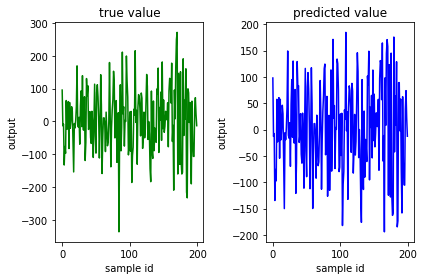

In [21]:
plt.subplot(1, 2, 1)
plt.plot(range(X_test.shape[0]), y_test, c="green")
plt.xlabel("sample id")
plt.ylabel("output")
plt.title("true value")
plt.subplot(1, 2, 2)
plt.plot(range(X_test.shape[0]), pred, c="blue")
plt.xlabel("sample id")
plt.ylabel("output")
plt.title("predicted value")
plt.tight_layout()